In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import sparse
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
import string
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from torch.utils.data import DataLoader, TensorDataset
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from nltk.stem import WordNetLemmatizer



# Step 1: Import Libraries and Load Data

# Define the paths to the training and test Excel files
train_file_path = 'D:/Oracle/training.xlsx'
test_file_path = 'D:/Oracle/test.xlsx'  

In [2]:
# Load the training data from the Excel file
train_df = pd.read_excel(train_file_path)

In [3]:
# Display the first few rows of the loaded training data
print(train_df.head())

        TweetId     Label                                          TweetText
0  3.042713e+17  Politics  '#SecKerry: The value of the @StateDept and @U...
1  3.048343e+17  Politics                            '@rraina1481 I fear so'
2  3.035690e+17    Sports  'Watch video highlights of the #wwc13 final be...
3  3.043666e+17    Sports  'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4  2.967709e+17    Sports  '@cricketfox Always a good thing. Thanks for t...


In [4]:
# Load the test data from the CSV file 
test_df = pd.read_excel(test_file_path)
# Display the first few rows of the loaded test data
print(test_df.head())

        TweetId                                          TweetText
0  3.064865e+17  '28. The home side threaten again through Maso...
1  2.863534e+17  '@mrbrown @aulia Thx for asking. See http://t....
2  2.895310e+17  '@Sochi2014 construction along the shores of t...
3  3.064517e+17  '#SecKerry\u2019s remarks after meeting with F...
4  2.979418e+17  'The #IPLauction has begun. Ricky Ponting is t...


In [5]:
# Step 2: Data Exploration and Visualization

# Display basic information about the dataset
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6525 entries, 0 to 6524
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TweetId    6525 non-null   float64
 1   Label      6525 non-null   object 
 2   TweetText  6525 non-null   object 
dtypes: float64(1), object(2)
memory usage: 153.1+ KB
None


In [6]:
# Count the number of instances for each class (label)
class_counts = train_df['Label'].value_counts()
print(class_counts)

Sports      3325
Politics    3200
Name: Label, dtype: int64


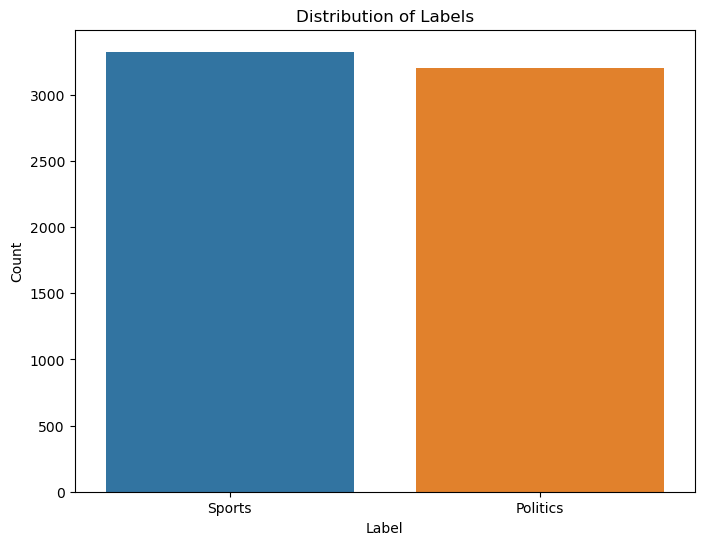

In [7]:
# Visualize the distribution of labels using a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [8]:
# Display statistics about the tweet text length
train_df['Text_Length'] = train_df['TweetText'].apply(lambda x: len(x.split()))
print(train_df['Text_Length'].describe())

count    6525.000000
mean       16.396015
std         5.593647
min         1.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        31.000000
Name: Text_Length, dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


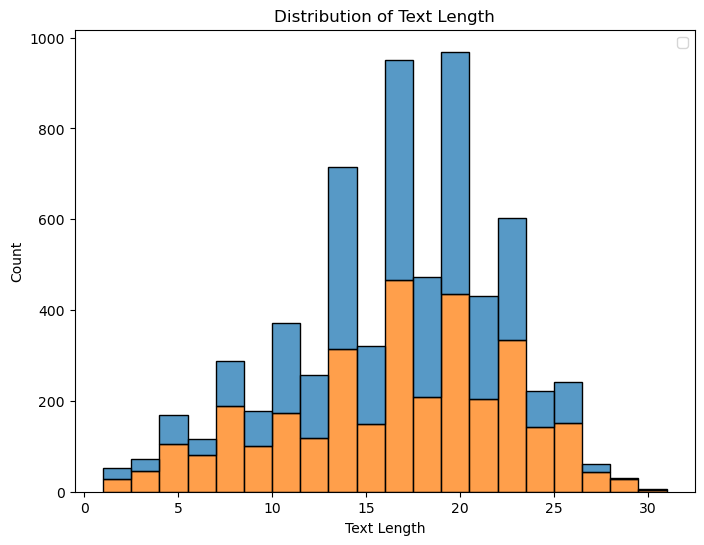

In [9]:
# Visualize the distribution of text length using a histogram
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='Text_Length', hue='Label', multiple='stack', bins=20)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.legend()
plt.show()

In [10]:
# Step 3: Data Cleaning and Lemmatization

def clean_text(text):
    # Remove links
    text = re.sub(r'http\S+', '', text)
    # Remove special characters and emojis
    text = re.sub(r'[^\w\s#@]', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Apply data cleaning and lemmatization to the 'TweetText' column
train_df['TweetText'] = train_df['TweetText'].apply(clean_text)
train_df['TweetText'] = train_df['TweetText'].apply(lemmatize_text)


In [13]:

# Split data into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: Sports and Politics

# Tokenize input data
train_tokens = tokenizer.batch_encode_plus(train_df['TweetText'].tolist(), padding=True, truncation=True, return_tensors='pt')
val_tokens = tokenizer.batch_encode_plus(val_df['TweetText'].tolist(), padding=True, truncation=True, return_tensors='pt')

# Convert labels to numerical values
label_encoder = LabelEncoder()
train_df['Label'] = label_encoder.fit_transform(train_df['Label'])
val_df['Label'] = label_encoder.transform(val_df['Label'])

# Create DataLoader for training and validation
train_dataset = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], torch.tensor(train_df['Label'].tolist()))
val_dataset = TensorDataset(val_tokens['input_ids'], val_tokens['attention_mask'], torch.tensor(val_df['Label'].tolist()))

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Set up optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        inputs, masks, labels = batch
        outputs = model(inputs, attention_mask=masks)[0]
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            inputs, masks, labels = batch
            outputs = model(inputs, attention_mask=masks)[0]
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.tolist())
            val_labels.extend(labels.tolist())

    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)
    val_recall = recall_score(val_labels, val_preds)
    val_precision = precision_score(val_labels, val_preds)

    print(f'Epoch {epoch+1} - Validation Accuracy: {val_accuracy:.4f} - F1 Score: {val_f1:.4f} - Recall: {val_recall:.4f} - Precision: {val_precision:.4f}')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\Users\hp\anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Validation Accuracy: 0.9565 - F1 Score: 0.9570 - Recall: 0.9517 - Precision: 0.9624
Epoch 2 - Validation Accuracy: 0.9641 - F1 Score: 0.9644 - Recall: 0.9554 - Precision: 0.9735
Epoch 3 - Validation Accuracy: 0.9565 - F1 Score: 0.9573 - Recall: 0.9591 - Precision: 0.9556


for the preprocessing 
Sports tweets often include numbers that represent scores, player statistics, game outcomes, and other sports-related information. These numbers can be crucial for distinguishing sports tweets from politics tweets.
*that is why i did not remove numbers from the tweets


After the training, we now proceed to the next step: applying the trained models to a new dataset without labels

In [ ]:
# Save the trained model to use i
model.save_pretrained(r'D:/Oracle/')

In [57]:

# Load the test data into a DataFrame 
test_df = pd.read_csv('D:/Oracle/test.csv', dtype={'TweetId': 'int64'})

# Define data cleaning and lemmatization functions
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s#@]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Apply data cleaning and lemmatization to the 'TweetText' column
test_df['TweetText'] = test_df['TweetText'].apply(clean_text)
test_df['TweetText'] = test_df['TweetText'].apply(lemmatize_text)

# Load pre-trained BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2) 

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Tokenize input data
test_tokens = tokenizer.batch_encode_plus(test_df['TweetText'].tolist(), padding=True, truncation=True, return_tensors='pt')

# Create DataLoader for test data
test_dataset = TensorDataset(test_tokens['input_ids'], test_tokens['attention_mask'])
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define hyperparameters
learning_rate = 1e-5  # Adjust as needed
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Apply the trained model on test data
model.eval()
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        inputs, masks = batch
        inputs, masks = inputs.to(device), masks.to(device)
        outputs = model(inputs, attention_mask=masks)[0]
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().tolist())

# Convert predictions back to labels
label_mapping = {0: 'Sports', 1: 'Politics'}
test_labels = [label_mapping[pred] for pred in test_preds]

# Create output DataFrame with 'TweetId' and 'Label' columns
output_df = pd.DataFrame({'TweetId': test_df['TweetId'], 'Label': test_labels})

# Save the predictions as a CSV file
output_path = 'D:/Oracle/submission.csv'
output_df.to_csv(output_path, index=False, float_format='%g')

# Print out the first few rows of the DataFrame to check
print(output_df.head())


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\Users\hp\anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


              TweetId     Label
0  306486520121012224  Politics
1  286353402605228032  Politics
2  289531046037438464  Politics
3  306451661403062273  Politics
4  297941800658812928  Politics


Text Classification Using Machine Learning

In [22]:

# Load the data
train_df = pd.read_csv('D:/Oracle/training.csv')
test_df = pd.read_csv('D:/Oracle/test.csv', dtype={'TweetId': 'int64'})

# Preprocessing
def preprocess_text(text):
    # Remove special characters, punctuation, links, and emojis
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'[^A-Za-z\s]+', '', text)
    return text

# Lemmatization
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

train_df['TweetText'] = train_df['TweetText'].apply(preprocess_text)
train_df['TweetText'] = train_df['TweetText'].apply(lemmatize_text)
test_df['TweetText'] = test_df['TweetText'].apply(preprocess_text)
test_df['TweetText'] = test_df['TweetText'].apply(lemmatize_text)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['TweetText'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['TweetText'])
y_train = train_df['Label']

# Train the Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

# Train Random Forest and Gradient Boosting models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf.toarray(), y_train)

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_tfidf.toarray(), y_train)

# Make predictions using all models
test_preds_lr = lr_model.predict(X_test_tfidf)
test_df['Label'] = test_preds_lr
test_df[['TweetId', 'Label']].to_csv('submission_lr.csv', index=False)

test_preds_rf = rf_model.predict(X_test_tfidf.toarray())
test_df['Label'] = test_preds_rf
test_df[['TweetId', 'Label']].to_csv('submission_rf.csv', index=False)

test_preds_gb = gb_model.predict(X_test_tfidf.toarray())
test_df['Label'] = test_preds_gb
test_df[['TweetId', 'Label']].to_csv('submission_gb.csv', index=False)


In [24]:
#performance

# Calculate and print the performance metrics for Logistic Regression
lr_accuracy_train = accuracy_score(y_train, lr_model.predict(X_train_tfidf))
lr_precision_train = precision_score(y_train, lr_model.predict(X_train_tfidf), pos_label='Sports')
lr_recall_train = recall_score(y_train, lr_model.predict(X_train_tfidf), pos_label='Sports')
lr_f1_train = f1_score(y_train, lr_model.predict(X_train_tfidf), pos_label='Sports')

print("Logistic Regression Performance on Training Data:")
print(f"Accuracy: {lr_accuracy_train:.4f}")
print(f"Precision: {lr_precision_train:.4f}")
print(f"Recall: {lr_recall_train:.4f}")
print(f"F1 Score: {lr_f1_train:.4f}\n")

# Calculate and print the performance metrics for Random Forest
rf_accuracy_train = accuracy_score(y_train, rf_model.predict(X_train_tfidf.toarray()))
rf_precision_train = precision_score(y_train, rf_model.predict(X_train_tfidf.toarray()), pos_label='Sports')
rf_recall_train = recall_score(y_train, rf_model.predict(X_train_tfidf.toarray()), pos_label='Sports')
rf_f1_train = f1_score(y_train, rf_model.predict(X_train_tfidf.toarray()), pos_label='Sports')

print("Random Forest Performance on Training Data:")
print(f"Accuracy: {rf_accuracy_train:.4f}")
print(f"Precision: {rf_precision_train:.4f}")
print(f"Recall: {rf_recall_train:.4f}")
print(f"F1 Score: {rf_f1_train:.4f}\n")

# Calculate and print the performance metrics for Gradient Boosting
gb_accuracy_train = accuracy_score(y_train, gb_model.predict(X_train_tfidf.toarray()))
gb_precision_train = precision_score(y_train, gb_model.predict(X_train_tfidf.toarray()), pos_label='Sports')
gb_recall_train = recall_score(y_train, gb_model.predict(X_train_tfidf.toarray()), pos_label='Sports')
gb_f1_train = f1_score(y_train, gb_model.predict(X_train_tfidf.toarray()), pos_label='Sports')

print("Gradient Boosting Performance on Training Data:")
print(f"Accuracy: {gb_accuracy_train:.4f}")
print(f"Precision: {gb_precision_train:.4f}")
print(f"Recall: {gb_recall_train:.4f}")
print(f"F1 Score: {gb_f1_train:.4f}\n")


Logistic Regression Performance on Training Data:
Accuracy: 0.9434
Precision: 0.9332
Recall: 0.9576
F1 Score: 0.9452

Random Forest Performance on Training Data:
Accuracy: 0.9922
Precision: 0.9881
Recall: 0.9967
F1 Score: 0.9924

Gradient Boosting Performance on Training Data:
Accuracy: 0.8562
Precision: 0.8158
Recall: 0.9272
F1 Score: 0.8680



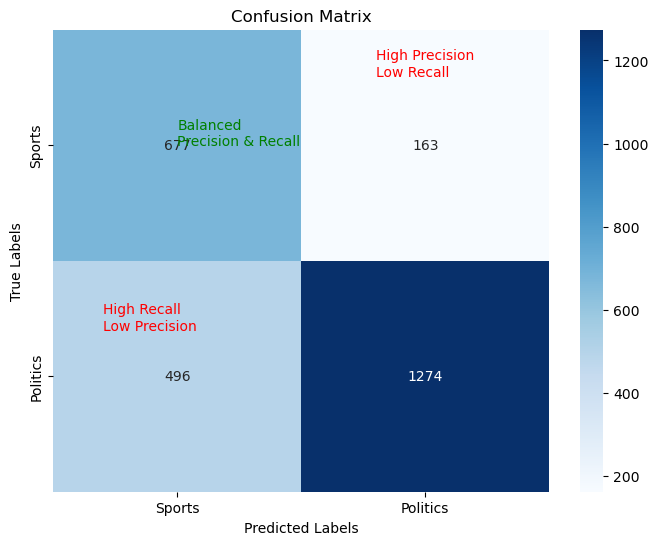

In [29]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True, fmt="d", cmap="Blues")

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(ticks=[0.5, 1.5], labels=["Sports", "Politics"])
plt.yticks(ticks=[0.5, 1.5], labels=["Sports", "Politics"])

# Add comment
plt.text(1.3, 0.2, "High Precision\nLow Recall", fontsize=10, color="red")
plt.text(0.2, 1.3, "High Recall\nLow Precision", fontsize=10, color="red")
plt.text(0.5, 0.5, "Balanced\nPrecision & Recall", fontsize=10, color="green")

# Display the plot
plt.show()


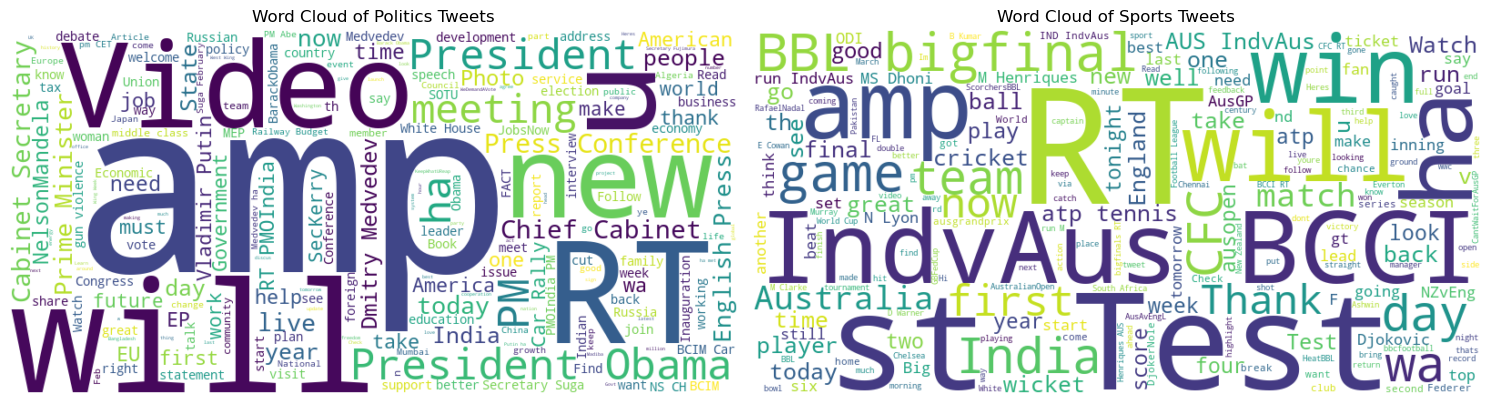

In [21]:
#CloudPlot
# Filter the data for politics and sports tweets
politics_text = ' '.join(train_df[train_df['Label'] == 'Politics']['TweetText'])
sports_text = ' '.join(train_df[train_df['Label'] == 'Sports']['TweetText'])

# Generate word cloud images for politics and sports tweets
politics_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(politics_text)
sports_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sports_text)

# Display the generated word clouds:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(politics_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Politics Tweets")

plt.subplot(1, 2, 2)
plt.imshow(sports_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Sports Tweets")

plt.tight_layout()
plt.show()
